In [76]:
import os
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [77]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize, PunktSentenceTokenizer, TweetTokenizer
from nltk.tokenize.punkt import PunktLanguageVars
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LassoCV,LogisticRegression,LogisticRegressionCV


from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist



In [78]:
#tknzr = word_tokenize() #TweetTokenizer()

stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words("english")

cv = CountVectorizer()

In [79]:
def preprocess(sentence, remove_stopWords=False, stem=False):
    
    # Remove markup
    #sentence = BeautifulSoup(sentence,'lxml').get_text()

    # Remove https links
    sentence = re.sub(r'https?:\/\/[aA-zZ0-9.\/-]+', '', sentence)
    
    # remove non-ascii character    
    sentence = re.sub(r"[^\x00-\x7F]+", "", sentence)

    # remove "\t" character
    sentence = " ".join(sentence.split("\t"))

    # Remove file paths
    sentence = re.sub(r'((\/|\\.*?\.[\w:]+) )', '', sentence)

    
    # sentence = sentence.replace(""""#$%&\'()*+-/:;<=>@[\\]^_`{|}~""", '')
   
    #remove pullet points
  #  sentence = re.sub(r'\d\.\s+|[a-z]\)\s+|\d\)\s+|•\s+|/\n[A-Z]\.\s+|[IVX]+\.\s+/g', "", sentence)
    
    # keep only spaces and alpha numeric
    sentence = re.sub(r"[^a-zA-Z\s'*\.]", ' ', sentence)
    
    # replace multiple continuous whitespace with a single whitespace
    #sentence = re.sub(r"\s{2,}", " ", sentence)
    
    # remove '
    sentence = re.sub('''[\']''','',sentence)
    
    # remove trailing whitespace
    sentence = sentence.strip()
    
    #lower
    sentence = sentence.lower()
    
    # fix some appreviations
    sentence = re.sub(" ive ", " i have ", sentence, flags=re.IGNORECASE)
    sentence = re.sub("  ill ", " i will ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" hell ", " he will ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" shell ", " she will ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" itll ", " it will ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" im ", " i am ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" hes ", " he is ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" shes ", " she is ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" its ", " it is ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" heres ", " here is ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" theres ", " there is ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" nt ", " not ", sentence, flags=re.IGNORECASE)
    sentence = re.sub(" theyre ", " they are ", sentence, flags=re.IGNORECASE)  

   # sentence = re.sub("no longer", " not", sentence, flags=re.IGNORECASE)

    


    # stem and remove stop words
    if remove_stopWords and stem:
        sentence = ' '.join([stemmer.stem(word) for word in sentence.split() if word not in stop_words])
    elif stem:
        sentence = ' '.join([stemmer.stem(word) for word in sentence.split()])
    elif remove_stopWords:
        sentence = ' '.join([word for word in sentence.split() if word not in stop_words])

        
    sentence = re.sub("\.", "*", sentence, flags=re.IGNORECASE)  
    sentence = re.sub("\*+", " ", sentence, flags=re.IGNORECASE)
    
    # replace multiple continuous whitespace with a single whitespace
    sentence = re.sub(r"\s{2,}", " ", sentence)



    return sentence

In [80]:
rev_filepath = os.getcwd() + '\\data\\reviews.csv'
rec_filepath = 'output.csv'


In [6]:
df_rev= pd.read_csv(rev_filepath, sep=';', error_bad_lines=False, warn_bad_lines=False, encoding= 'unicode_escape')
df_rec= pd.read_csv(rec_filepath, sep=',', error_bad_lines=False, warn_bad_lines=False, encoding= 'unicode_escape')['RecipeID']


In [7]:
df_rev['flag_num'] = df_rev['RecipeID'].apply(lambda x: 1 if str(x).isnumeric() else 0)
df_rev = df_rev[df_rev['flag_num']==1]
df_rev['RecipeID'] = df_rev['RecipeID'].astype(int)

del df_rev['flag_num']

In [8]:
df_m = df_rev.merge(df_rec, on='RecipeID' )[df_rev.columns]

In [81]:
df_m

,RecipeID,profileID,Rate,Comment
0,7000,675719,5,'Oh Yay! I''ve never made any kind of bread f...
1,7000,1478626,5,These rolls are wonderful. I had to bake them ...
2,7000,608663,5,This recipe was made for a group of 120 in a c...
3,7000,2785736,5,WOO HOO.. I did it with the help from my fello...
4,7000,594474,5,"'These are great!! Not a croissant, but much l..."
...,...,...,...,...
1095679,27511,3323773,5,This cake was fantastic. Refridgerating it ove...
1095680,27511,1490790,5,'This was the best cake I''ve ever made! I was...
1095681,27511,2280040,5,'This was so incredbily yummy! I made it for ...
1095682,27511,3298475,4,"'This combo is good, but not the best I ever h..."


In [11]:
corpus = {}
for rid in tqdm(df_m['RecipeID'].unique()):
    temp = df_m[df_m['RecipeID']==rid].copy()
    txt = '**'.join([str(i) for i in temp['Comment'].to_list()])
    corpus[rid] =  preprocess(txt, remove_stopWords=True, stem=True)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6426/6426 [11:48<00:00,  9.07it/s]


In [14]:
df_new = pd.DataFrame.from_dict(corpus,orient='index', columns=['reviews'])

In [82]:
df_new

,reviews
7000,oh yay never made kind bread scratch realli ne...
7001,tri match fantast poppi seed bread purchas men...
7003,bread absolut wonderful split recip use half i...
7009,despit review say isnt whole wheat bread recip...
7013,love result alter recipe use larg banana c oil...
...,...
27341,interest good chose recip first place decid fo...
27342,dont intimid recip experi baking truli make ex...
27478,made cheesecak sever time devour time import t...
27491,made cake exact indic howev increas batter dou...


In [26]:
print('BEFORE:-')
print(df_m.iloc[0,3][:130])
print()
print('After:-')
print(df_new.iloc[0,0][:70])

BEFORE:-
'Oh Yay!  I''ve never made any kind of bread from scratch before, and I was really nervous about this one.  I was simply ASTOUNDED

After:-
oh yay never made kind bread scratch realli nervous one simpli astound


In [27]:
#df_rec['Ingredients'] = df_rec['Ingredients'].apply(lambda x: re.sub('''[\']''','',x).strip()


vec = cv.fit(df_new['reviews'])
cnt_vec = vec.transform(df_new['reviews'])
sum_words = cnt_vec.sum(axis=0)
words_freq = {word: sum_words[0, idx] for word, idx in tqdm(vec.vocabulary_.items())}
words_freq ={k:v for i,(k,v) in tqdm(enumerate(sorted(words_freq.items(), key=lambda x: x[1], reverse=True)))}
words_freq


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 67417/67417 [00:00<00:00, 474376.67it/s]
67417it [00:00, 919431.22it/s]


{'use': 384340,
 'recip': 344190,
 'make': 277386,
 'made': 262665,
 'good': 219213,
 'love': 186619,
 'ad': 185226,
 'great': 179780,
 'like': 150090,
 'time': 147242,
 'easi': 139933,
 'thi': 131902,
 'it': 104267,
 'also': 98850,
 'tast': 95754,
 'this': 95633,
 'one': 94780,
 'instead': 91407,
 'didnt': 90563,
 'realli': 89515,
 'recipe': 88068,
 'littl': 86216,
 'delici': 84009,
 'chicken': 82824,
 'cake': 82587,
 'add': 81610,
 'cup': 76681,
 'flavor': 76664,
 'sugar': 73547,
 'cook': 71859,
 'tri': 71651,
 'would': 68634,
 'famili': 68506,
 'cream': 66764,
 'follow': 65851,
 'turn': 61231,
 'chang': 61057,
 'sauc': 59395,
 'butter': 59179,
 'much': 57647,
 'husband': 57562,
 'review': 56047,
 'first': 55447,
 'next': 55227,
 'best': 54495,
 'bake': 54417,
 'half': 53340,
 'perfect': 53036,
 'even': 51821,
 'garlic': 51405,
 'chees': 50848,
 'onion': 50671,
 'bit': 50524,
 'thank': 49495,
 'veri': 49285,
 'mix': 48466,
 'cooki': 48297,
 'soup': 48144,
 'sweet': 47836,
 'everyon':

In [28]:
tfidf = TfidfTransformer(smooth_idf=True,use_idf=True)
tf_idf_vec = tfidf.fit_transform(cnt_vec)



In [32]:
V = tf_idf_vec.todense()


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
V.shape

(6426, 67417)

In [68]:
c=100
print('Keywords for RecipeID', df_new.reset_index().iloc[c,0], ':-')
print({vec.get_feature_names()[i]:V[c,i] for i in np.array(np.argsort(-V[c])[0,:3]).flatten()})
print()
c=0
print('Keywords for RecipeID', df_new.reset_index().iloc[c,0], ':-')
print({vec.get_feature_names()[i]:V[c,i] for i in np.array(np.argsort(-V[c])[0,:3]).flatten()})
print()
c=3000
print('Keywords for RecipeID', df_new.reset_index().iloc[c,0], ':-')
print({vec.get_feature_names()[i]:V[c,i] for i in np.array(np.argsort(-V[c])[0,:3]).flatten()})

Keywords for RecipeID 7453 :-
{'cake': 0.5683587140175906, 'caramel': 0.38027828100935585, 'snicker': 0.31266935526030043}

Keywords for RecipeID 7000 :-
{'roll': 0.5478522244129832, 'crescent': 0.37313901308055225, 'dough': 0.2964995567031279}

Keywords for RecipeID 15118 :-
{'broccoli': 0.4892810672279031, 'soup': 0.45152498474451846, 'cheddar': 0.2600545800984578}


In [ ]:
def spy(A, figsize=(4, 100), markersize=0.1):
    """Visualizes a sparse matrix."""
    fig = plt.figure(figsize=figsize)
    plt.spy(A, markersize=markersize)
    plt.show()
    
spy(tf_idf_vec)

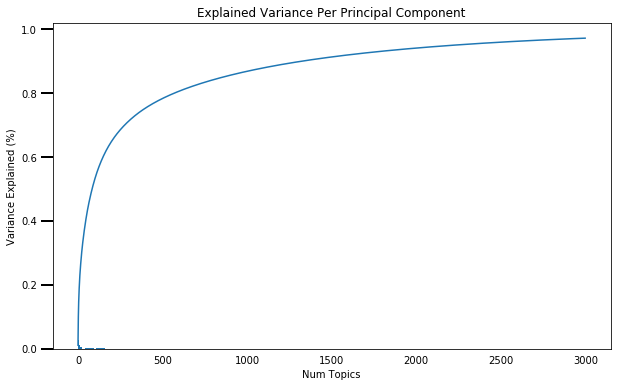

In [70]:

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components             
    '''
    num_components = len(pca.explained_variance_ratio_) ## num of Principal components (PCs)
    ind = np.arange(num_components) # create an index list
    vals = pca.explained_variance_ratio_ # show the % of vaition explained by each PC
    cumvals = np.cumsum(vals) # cummulative sum to see the % of vaiation explained by PC1+PC2+PC3+....+PCn

    ## plotting
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.bar(ind, vals) # create bar plot to show %var explained by each PC
    ax.plot(ind, cumvals) # create line plot to show % increase in exp variance for every added PC
 
    ## set plot lables
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    ax.set_xlabel("Num Topics")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    return {i:v for i,v in zip(ind,cumvals) if v<=99}
    
# Apply PCA to the data.
pca = TruncatedSVD(n_components=3000, random_state=45)
X_pca = pca.fit_transform(tf_idf_vec) ## fit it to the data to generate the PCs

plot = scree_plot(pca) # call the function above


In [71]:
svd = TruncatedSVD(n_components=500, random_state=45)
X_svd = svd.fit_transform(tf_idf_vec)

In [72]:
pd.DataFrame(X_svd, index=df_new.index).to_csv('tfid.csv')

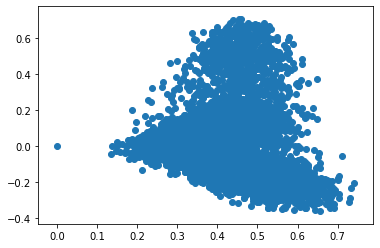

In [17]:
plt.scatter(X_svd[:,0],X_svd[:,1])

In [ ]:
M = tf_idf_vec.todense()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.17s/it]


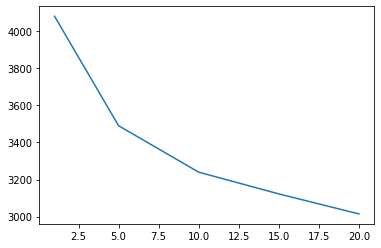

In [18]:
center = {}
for i in tqdm([1,5,10,15,20]):
    init = KMeans(i)
    model = init.fit(X_svd)
    #label = model.predict(M)
    center[i] = model.inertia_

lists = sorted(center.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [20]:
init = KMeans(10)
model = init.fit(X_svd)
c_labels = model.predict(X_svd)
np.unique(c_labels,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 516,  639,  479, 1391,  388,  185,  642, 1396,  332,  458],
       dtype=int64))

In [ ]:
IF = IsolationForest(random_state=0,contamination=0.01)
c_labels = IF.fit_predict(X_svd)
np.unique(c_labels,return_counts=True)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_svd, c_labels, test_size=0.2, shuffle = True, random_state = 8)

NameError: name 'c_labels' is not defined

In [26]:
#search=LogisticRegressionCV(cv=5, random_state=0,penalty='l1',class_weight='balanced', solver='saga', verbose=3)
#search=LogisticRegression(penalty='l1', solver='saga')
search=LogisticRegression(penalty='l1',class_weight='balanced', solver='saga')

search.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', penalty='l1', solver='saga')

In [ ]:
LassoCV_model = LassoCV(cv=10)
LassoCV_model.fit(X_train[,y_train)
alphas, coefs, _ = LassoCV_model.path(A, y) # to show path of coeffs.

In [29]:
features = list(range(X_svd.shape[1]))
coefficients =search.coef_[0]
importance = np.abs(coefficients)
imp_features = np.array(features)[importance > 0]
len(imp_features)
imp_features

array([ 0,  1,  4,  5,  8,  9, 11, 12])

In [31]:
y_pred_test = search.predict(X_test)
y_pred_train = search.predict(X_train)

print("train_Accuracy:",metrics.accuracy_score(y_train, y_pred_train))

print()
print("test_Accuracy:",metrics.accuracy_score(y_test, y_pred_test))


train_Accuracy: 0.9649805447470817

test_Accuracy: 0.9642301710730948


In [ ]:
out = []

for i in tqdm(range(M.shape[0])):
    v = np.array(M[i]).squeeze()
    idxs = np.argsort(-v)[:50]

    out.append({cv.get_feature_names()[i]:v[i] for i in idxs})
    


In [ ]:
df_new_2 = pd.concat([df_new, pd.DataFrame(out, index =df_new.index)], axis=1)

In [ ]:
t = df_new_2.iloc[:,1:].fillna(0)

In [32]:
from sklearn.manifold import MDS, Isomap, TSNE
embedding = TSNE(n_components=2, n_jobs=-1)
X_transformed = embedding.fit_transform(X_svd[:,imp_features])
X_transformed.shape

(6426, 2)

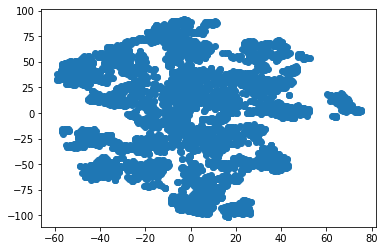

In [37]:
plt.scatter(X_transformed[:,0],X_transformed[:,1])

In [45]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.01, min_samples=2).fit(X_svd[:,imp_features])
clustering.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

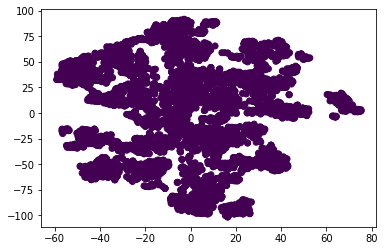

In [46]:
plt.scatter(X_transformed[:,0],X_transformed[:,1], c=clustering.labels_)

In [42]:
labels = clustering.labels_
cc = np.unique(clustering.labels_, return_counts=True)
for i,c in enumerate(cc[1]):
    if c> 100:
        labels[labels==cc[0][i]] = 0
    else:
        labels[labels==cc[0][i]] = 1
    

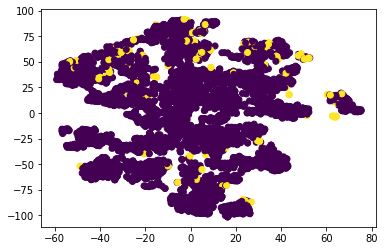

In [44]:
plt.scatter(X_transformed[:,0],X_transformed[:,1], c=labels)

In [ ]:
tf_idf_vec.shape